# Hans 2024 data

Should probably formalize this as a Luigi or Airflow pipeline, but for now let's get everything set up interactively in notebooks so we can plot along the way.

## TODO:
1. ~~Fix inclusion of too short fragments in scoring, or allow it on purpose.~~

    Let's allow it on purpose - we can always filter the short fragments out later or even train multiple classifiers for different length ranges. I would like to be able to give a score for short fragments, even if it come with a caveat about reduced accuracy on shorter text. I just know people are going to want to use this thing on tweets...

2. Set longer length limit for Falcon, possibly using sequential device map or even CPU.
    
    Some complexity here - thinking maybe we should be using the 'auto' device map, it can handle longer sequences and works just as fast as a single K80, but that implies we have to keep loading and reloading the base and instruction tuned models. We could batch - do the reader calculations for a set of fragments and then switch models to do the writer calculations. Also, should probably set the length limit to ~1000 words. Given the length distribution of texts in the original dataset, that's pretty much the high end of the synthetic texts, but it's not very long for the human. Need to be careful how we sample lengths - want our length distributions to end up similar.
    
3. ~~Score both matched fragments from row in Hans data. More data is better!~~
4. ~~Shuffle data before train-test split such that training data is not mostly or all from the same sub-dataset.~~

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config

/mnt/arkk/llm_detector/classifier


Load and combine the scored text fragment data from the Hans 2024 corpus.

In [2]:
datasets = {
    # 'cc_news': 'cc_news-scores.json',
    # 'pubmed': 'pubmed-scores.json',
    # 'cnn': 'cnn-scores.json'
    'falcon': 'falcon-7b_scores.json'
}

dataframes = []

for dataset, filename in datasets.items():

    print(f'\nRaw {dataset} dataset:')

    dataframe = pd.read_json(f'{config.HANS_DATA_PATH}/{filename}')

    # Replace and remove string 'OOM' and 'NAN' values
    dataframe.replace('NAN', np.nan, inplace = True)
    dataframe.replace('OOM', np.nan, inplace = True)
    dataframe.dropna(inplace = True)

    # Update name of score column, some earlier runs called
    # it by the old names
    dataframe.rename(columns = {
        'Binoculars score': 'Perplexity ratio score',
        'Observer peak memory (GB)': 'Reader peak memory (GB)',
        'Performer peak memory (GB)': 'Writer peak memory (GB)'
    }, inplace = True)

    dataframe.info()

    # Fix some d-types
    dataframe = dataframe.astype({
        'Fragment': int,
        'Fragment length (tokens)': int,
        'Reader peak memory (GB)': float,
        'Writer peak memory (GB)': float,
        'Perplexity': float,
        'Cross-perplexity': float,
        'Perplexity ratio score': float
    })

    # get rid of some unnecessary columns
    dataframe.drop([
        'Fragment', 
        'Reader peak memory (GB)', 
        'Writer peak memory (GB)'
    ], axis = 1, inplace = True)

    dataframes.append(dataframe)

# Combine the individual datasets
data_df = pd.concat(dataframes, axis = 0)

# Shuffle the deck, resetting the index
data_df = data_df.sample(frac = 1).reset_index(drop = True)
data_df.reset_index(inplace = True, drop = True)

print('\nCombined dataset:')
data_df.info()


Raw falcon dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 121090 entries, 0 to 121130
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Fragment                  121090 non-null  int64  
 1   Fragment length (tokens)  121090 non-null  object 
 2   Dataset                   121090 non-null  object 
 3   Source                    121090 non-null  object 
 4   String                    121090 non-null  object 
 5   Reader peak memory (GB)   121090 non-null  float64
 6   Writer peak memory (GB)   121090 non-null  float64
 7   Perplexity                121090 non-null  object 
 8   Cross-perplexity          121090 non-null  object 
 9   Perplexity ratio score    121090 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 10.2+ MB

Combined dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121090 entries, 0 to 121089
Data columns (total 7 columns):
 #   Colu

Take a quick look for sanity...

In [3]:
# Get human and synthetic fragments
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

# Get the size of each
human_fragment_count = len(human_fragments)
synthetic_fragment_count = len(synthetic_fragments)

# And the percent synthetic
percent_synthetic = round((synthetic_fragment_count / (synthetic_fragment_count + human_fragment_count)) * 100, 1)

print(f'Have {human_fragment_count} human text fragments and {synthetic_fragment_count} synthetic fragments.')
print(f'Dataset is {percent_synthetic}% synthetic fragments.')

Have 89045 human text fragments and 32045 synthetic fragments.
Dataset is 26.5% synthetic fragments.


In [4]:
data_df.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
0,153,pubmed-llama2-13,human,many of whom had been trained as physical scie...,2.936,2.931641,1.001332
1,69,cnn-llama2-13,synthetic,who claims his daughter and Amanda are still v...,3.107,3.218750,0.965413
2,162,cc_news-falcon7,synthetic,one of several in recent days that have shatte...,1.941,2.216797,0.875771
3,226,pubmed-llama2-13,human,captured t - segment can not be held in the in...,2.555,2.707031,0.943723
4,446,pubmed-llama2-13,human,relationship for immature ticks .\nwe compiled...,2.130,2.218750,0.960387


In [5]:
data_df.tail()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
121085,271,cc_news-falcon7,synthetic,“Gentry asked for and received permission to s...,2.168,2.542969,0.852535
121086,92,cc_news-llama2-13,synthetic,"(CAC), the government-run office employs 20,00...",2.662,3.152344,0.844486
121087,169,cnn-falcon7,synthetic,"White House summit on college costs, the firs...",2.178,2.576172,0.845337
121088,231,cc_news-llama2-13,human,with 207 yards and four touchdowns. He is one ...,2.072,2.318359,0.893850
121089,349,pubmed-llama2-13,human,comparison study between this stent and a conv...,2.729,2.658203,1.026451


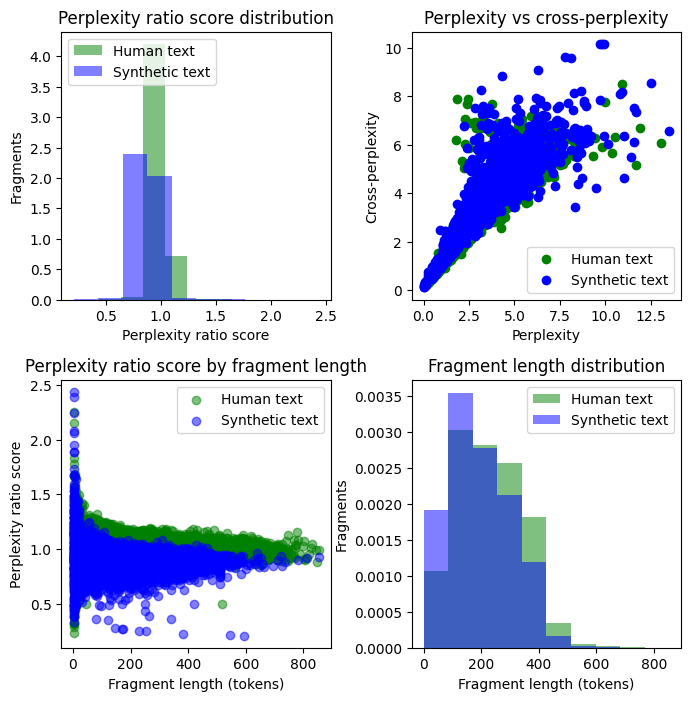

In [6]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

Something strange in the fragment length vs perplexity ratio score plot - the minimum fragment length should be 50 words? Not sure what is going on... let's take a closer look.

In [7]:
short_fragments = human_fragments[human_fragments['Fragment length (tokens)'] < 10]
short_fragments.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
417,8,cc_news-llama2-13,human,seasons in and still going strong.,5.570,5.835938,0.954485
1223,2,cnn-llama2-13,human,article.,2.620,6.917969,0.378600
1237,7,cc_news-llama2-13,human,"12, at Homebush.",4.555,4.570312,0.996581
1272,9,pubmed-llama2-13,human,l of 5% sds .,4.555,5.382812,0.846154
1638,8,pubmed-llama2-13,human,diagnostic criteria to be defined .,4.710,5.140625,0.916413


Yeah, looks like we have some weird stuff - apparently the extra ends of sentences get used? This could be a problem with how we did the sampling from the larger blocks of text contained in the Hans corpus. We don't have time to go back and fix it, but we can prevent those scores from being carried forward at this step. Let's threshold the length before we save.

Yeah, side note, found it. From perplexity_ratio.py in the benchmarking functions (line 147):

```text
    # If the slice length is greater than the
    # length of the input tokens, use all of
    # them
    if slice_length > total_length:
        slice_length = total_length
```

Also, bad terminological specificity here - we are actually talking about words.... not tokens.

In [8]:
data_df = data_df[data_df['Fragment length (tokens)'] > 50]

human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

OK - plot again just for sanity check.

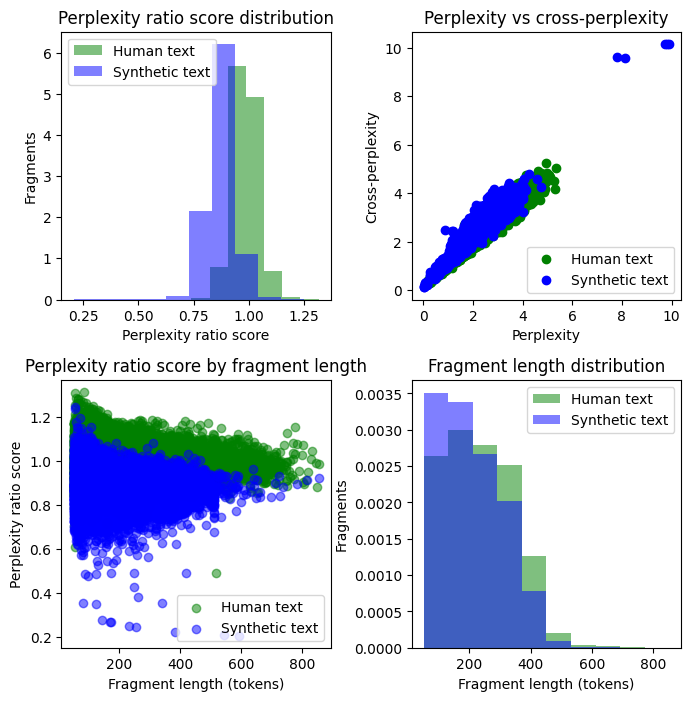

In [9]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'lower right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

OK, good, looks good, actually much better. Let's clip those high outliers on the perplexity/cross perplexity plot.

In [10]:
data_df = data_df[(data_df['Perplexity'] < 6) & (data_df['Cross-perplexity'] < 6)]

human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

In [11]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_DATA

with open(output_file, 'w') as file:
    file.write(data_df.to_json())

Next, let's split the data in to training and testing subsets. This way as we do the feature engineering steps we are not leaking data.

In [12]:
training_df = data_df.sample(frac = 0.8, random_state = 42)
testing_df = data_df.drop(training_df.index)

training_df.reset_index(inplace = True, drop = True)
testing_df.reset_index(inplace = True, drop = True)

print(f'Have {len(training_df)} training examples')
print(f'Have {len(testing_df)} testing examples')
print()
testing_df.info()

Have 93526 training examples
Have 23382 testing examples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23382 entries, 0 to 23381
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (tokens)  23382 non-null  int64  
 1   Dataset                   23382 non-null  object 
 2   Source                    23382 non-null  object 
 3   String                    23382 non-null  object 
 4   Perplexity                23382 non-null  float64
 5   Cross-perplexity          23382 non-null  float64
 6   Perplexity ratio score    23382 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.2+ MB


And finally, save the split data for future use.

In [13]:
# Save testing data
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA

with open(output_file, 'w') as file:
    file.write(training_df.to_json())

# Save testing data
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA

with open(output_file, 'w') as file:
    file.write(testing_df.to_json())